<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>


# 4장: 밑바닥부터 GPT 모델 구현하기

In [1]:
from importlib.metadata import version

print("맷플롯립 버전:", version("matplotlib"))
print("파이토치 버전:", version("torch"))
print("tiktoken 버전:", version("tiktoken"))

맷플롯립 버전: 3.10.8
파이토치 버전: 2.9.1+cu126
tiktoken 버전: 0.12.0


- 이 장에서 GPT와 유사한 LLM 구조를 구현합니다. 다음 장에서는 이 LLM 훈련하는데 초점을 맞추겠습니다.

<img src="images/llm_from_scratch/ch04_compressed/01.webp" width="800px">

## 4.1 구조 구현하기

- 1장은 GPT와 Llama 같은 모델을 소개했습니다. 이런 모델은 원본 트랜스포머 구조의 디코더 부분을 기반으로 순차적으로 단어를 생성합니다.
- 따라서 이런 LLM을 종종 디코더 기반 LLM이라 부릅니다.
- 전통적인 딥러닝 모델과 비교하면 LLM은 규모가 큽니다. 이는 코드의 양이 아니라 방대한 파라미터 개수 때문입니다.
- 앞으로 보겠지만 LLM 구조의 많은 구성 요소가 반복적입니다.

<img src="images/llm_from_scratch/ch04_compressed/02.webp" width="600px">

- 이전 장에서 설명의 편의를 위해 토큰 입력과 출력의 임베딩 차원을 작게 했습니다.
- 이 장에서는 작은 GPT-2 모델와 같은 임베딩 크기를 사용합니다.
- 구체적으로 Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)에 나온 가장 작은 GPT-2 모델 구조(1억 2,400만 파라미터)를 구현하겠습니다(처음에는 1억 1,700만 파라미터라고 보고되었지만 나중에 모델 저장소에 수정된 값으로 공개되었습니다).
- 여기서 구현한 모델은 3억 4,500만 파라미터, 7억 6,200만 파라미터, 15억 4,200만 파라미터를 가진 모델과 호환됩니다. 5장에서 이 구현에 사전 훈련된 가중치를 로드하는 방법을 알아 보겠습니다.

- 1억 2,400만 파라미터 GPT-2 모델의 설정은 다음과 같습니다:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘사전 크기
    "context_length": 1024, # 문맥 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 층 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리, 키, 값을 만들 때 편향 포함 여부
}

- `"vocab_size"`는 BPE 토크나이저(2장 참조)에서 사용할 50,257 토큰으로 구성된 어휘 사전 크기를 나타냅니다.
- `"context_length"`는 위치 임베딩(2장 참조)으로 모델이 다룰 수 있는 입력 토큰의 최대 개수입니다.
- `"emb_dim"`은 임베딩 크기를 나타내며, 각 토큰을 768 차원의 벡터로 변환합니다.
- `"n_heads"`는 멀티 헤드 어텐션 메커니즘(3장 참조)에 있는 어텐션 헤드의 개수입니다.
- `"n_layers"`에는 모델에 있는 (이 장에서 소개할) 트랜스포머 블록의 개수를 지정합니다.
- `"drop_rate"`는 과대적합을 막기 위한 드롭아웃 메커니즘(3장 참조)의 강도를 지정합니다(0.1은 은닉 유닛의 10%를 랜덤하게 제외한다는 의미입니다).
- `"qkv_bias"`는 멀티 헤드 어텐션의 Linear 층에서 쿼리, 키, 값을 계산할 때 편향 유닛을 도입할지 여부를 결정합니다. 현대적인 LLM의 구성 방식을 따라서 처음에는 이 값을 비활성화하지만 오픈AI의 사전 훈련된 GPT-2 가중치를 모델로 로드할 때 이를 다시 살펴 보겠습니다(5장 참조).

<img src="images/llm_from_scratch/ch04_compressed/03.webp" width="800px">

In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 더미 클래스

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 층 정규화 인터페이스를 흉내내기 위한 매개변수

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x

<img src="images/llm_from_scratch/ch04_compressed/04.webp" width="650px">

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("출력 크기:", logits.shape)
print(logits)

출력 크기: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**노트**

- 이 코드를 윈도나 리눅스에서 실행하면 결괏값이 다음처럼 보일 수 있습니다:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 이는 난수 때문이며 문제가 되지 않으므로 이 장의 나머지 코드를 실행하는데 이슈가 없습니다.
- 이런 차이가 생기는 한 가지 이유는 `nn.Dropout`이 파이토치가 컴파일된 운영체제에 따라 다르게 동작하기 때문입니다. 자세한 내용은 [파이토치 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)를 참고하세요.

---

## 4.2 층 정규화로 활성화 정규화하기

- LayerNorm([Ba et al. 2016](https://arxiv.org/abs/1607.06450))이라고도 불리는 층 정규화는 신경망 층의 활성화를 평균이 0이고 분산이 1이 되도록 조정합니다.
- 이를 통해 훈련을 안정화하고 가중치 수렴 속도를 높일 수 있습니다.
- 나중에 구현하겠지만 층 정규화는 트랜스포머 블록의 멀티 헤드 어텐션 모듈 전후에 적용됩니다. 또한 최종 출력 층 전에도 적용됩니다.

<img src="images/llm_from_scratch/ch04_compressed/05.webp" width="600px">

- 작은 입력 샘플을 간단한 신경망 층에 통과시켜 층 정규화의 작동 방식을 알아 보죠:

In [6]:
torch.manual_seed(123)

# 다섯 개의 차원(특성)을 가진 두 개의 훈련 샘플을 만듭니다.
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 두 개의 입력에 대해 각각 평균과 분산을 계산해 보겠습니다:

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
분산:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 정규화는 두 입력(행)에 대해 독립적으로 적용됩니다. dim=-1을 사용하면 행 차원이 아니라 마지막 차원(이 경우 특성 차원)을 따라 계산이 수행됩니다.

<img src="images/llm_from_scratch/ch04_compressed/06.webp" width="600px">

- 평균을 빼고, 분산의 제곱근(표준편차)으로 나누면 입력을 열(특성) 차원을 따라 평균이 0이고 분산이 1이 되도록 만듭니다:

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("정규화된 층 출력:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

정규화된 층 출력:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
평균:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 각 입력의 평균은 0이고 분산은 1입니다. 결과를 보기 쉽도록 파이토치의 과학적 표기법을 끌 수 있습니다:

In [9]:
torch.set_printoptions(sci_mode=False)
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 위에서 각 입력의 특성을 정규화했습니다.
- 이제 동일한 아이디어를 사용해 `LayerNorm` 클래스를 구현해 보죠:

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # correction=0
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**스케일 조정과 이동**

- 평균을 빼고, 분산으로 나누어 정규화하는 것 이외에 두 개의 훈련 가능한 파라미터 `scale`과 `shift`를 추가했습니다.
- 초기 `scale`(1)과 `shift`(0)은 아무런 영향을 미치지 못합니다. 하지만 `scale`과 `shift`가 훈련 가능한 파라미터이기 때문에 훈련 과정에서 두 파라미터를 조정하는 것이 훈련 작업에서 모델의 성능을 향상시킨다고 판단하는 경우 LLM이 자동으로 조정합니다.
- 이를 통해 모델은 처리하는 데이터에 가잘 잘 맞는 스케일 조정과 이동을 학습할 수 있습니다.
- 분산의 제곱근을 계산할 때 작은 값(`eps`)를 더합니다. 이는 분산이 0일 경우 0 나눗셈 오류를 방지하기 위해서입니다.

**편향된 분산**
- 위 분산 계산에서 `unbiased=False`는 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 식으로 분산을 계산한다는 의미입니다. `n`은 샘플 크기입니다(여기서는 특성 또는 열 개수). 이 공식은 (분모가 `n-1`인) 베셀 보정(Bessel's correction)을 사용하지 않습니다. 따라서 편향된 분산을 추정합니다.
- LLM에서 임베딩 차원 `n`은 매우 크므로 `n`과 `n-1`을 사용하는 차이는 무시할 수 있습니다.
- 하지만 GPT-2가 정규화 층에 편향된 분산을 사용했으므로 나중에 사전 훈련된 가중치를 로드할 때 호환성을 위해 동일한 방식을 적용했습니다.
- 이제 `LayerNorm`을 실제로 테스트해 보죠:

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="images/llm_from_scratch/ch04_compressed/07.webp" width="700px">

## 4.3 GELU 활성화 함수를 사용하는 피드 포워드 네트워크 구현하기

- 이 절에서 LLM의 트랜스포머 블록에서 사용되는 작은 신경망 모듈을 구현합니다.
- 딥러닝에서는 ReLU(Rectified Linear Unit) 활성화 함수가 간단하며 다양한 신경망 구조에서 효과적이기 때문에 널리 사용됩니다.
- LLM에서는 전통적인 ReLU 외에도 다양한 종류의 활성화 함수가 사용됩니다. 대표적인 두 개의 함수는 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)입니다.
- GELU와 SwiGLU는 각각 가우스 오차 함수와 시그모이드 GLU(gated linear unit)을 사용한 더 복잡하고 부드러운 활성화 함수입니다. 간단한 ReLU와 달리 딥러닝 모델의 성능을 향상시킵니다.

- GELU 활성화 함수([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))는 여러 방법으로 구현할 수 있습니다. 정확한 정의는 GELU(x) = x⋅𝛷(x)입니다. 여기서 𝛷(x)는 표준 가우스 누적 분포 함수(가우스 오차 함수)입니다.
- 실제로는 계산하기 쉬운 근사식으로 구현합니다: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (원본 GPT-2 모델도 커브 피팅(curve fitting)으로 찾은 이 근사식을 사용했습니다).

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

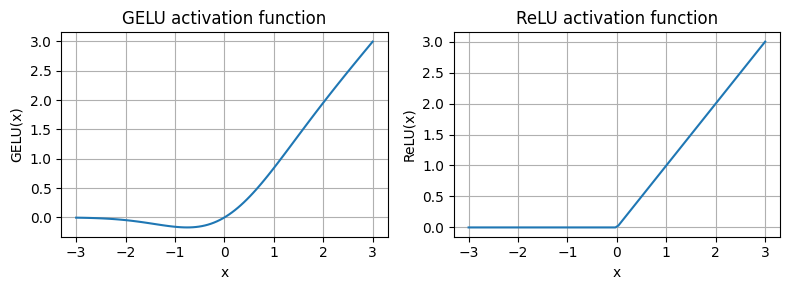

In [15]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 샘플 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 여기서 보듯이 ReLU는 양수는 그대로 출력하고 음수는 모두 0을 출력하는 구간별 선형 함수(piecewise linear function)입니다.
- GELU는 부드러운 비선형 함수로, ReLU와 비슷하지만 모든 음수 값의 그레이디언트를 0으로 만들지 않습니다(대략 x = -0.75에서는 그레이디언트가 0이 됩니다).
- 그다음 LLM의 트랜스포머 블록에 사용할 작은 신경망 모듈인 `FeedForward`를 구현해 보죠:

In [16]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="images/llm_from_scratch/ch04_compressed/09.webp" width="600px">

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)

# 입력 크기: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


입력에서 필요한 정보를 추출할 때 좀 더 잘 추출하기 위해 뻥튀기를 함

<img src="images/llm_from_scratch/ch04_compressed/10.webp" width="600px">

<img src="images/llm_from_scratch/ch04_compressed/11.webp" width="600px">

## 4.4 숏컷 연결 추가하기

- 스킵 연결(skip connection)이나 잔차 연결(residual connection)이라고도 부르는 숏컷 연결(shortcut connection) 이면의 개념을 알아 보죠.
- 원래 숏컷 연결은 컴퓨터 비전 분야의 심층 신경망(구체적으로 잔차 신경망(residual network))에서 그레이디언트 소실 문제를 완화하기 위해 제안되었습니다.
- 숏컷 연결이 그레이디언트가 한 개 이상의 층을 건너 뛰어 네트워크에 흐를 수 있도록 짧은 다른 경로를 만든다는 것을 보여줍니다.
- 이런 경로는 한 층의 출력을 이후 층의 출력에 더하여 만들어집니다.
- 작은 샘플 네트워크로 이 아이디어를 설명해 보죠:

<img src="images/llm_from_scratch/ch04_compressed/12.webp" width="600px">

- 코드로 구현하면 다음과 같습니다:

In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 현재 층의 출력을 계산합니다.
            layer_output = layer(x)
            # 숏컷 연결을 적용할 수 있는지 확인합니다.
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 정방향 계산
    output = model(x)
    target = torch.tensor([[0.]])

    # 타깃과 출력의 가까운 정도를 기반으로 손실을 계산합니다.
    loss = nn.MSELoss()
    loss = loss(output, target)

    # 그레이디언트를 계산하기 위한 역전파
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 가중치의 그레이디언트의 평균 절댓값을 출력합니다.
            print(f"{name}의 평균 그레이디언트는 {param.grad.abs().mean().item()}입니다.")

- 숏컷 연결이 **없을** 때 그레디언트 값을 출력해 보죠:

In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight의 평균 그레이디언트는 0.00020173590746708214입니다.
layers.1.0.weight의 평균 그레이디언트는 0.0001201116101583466입니다.
layers.2.0.weight의 평균 그레이디언트는 0.0007152042235247791입니다.
layers.3.0.weight의 평균 그레이디언트는 0.0013988739810883999입니다.
layers.4.0.weight의 평균 그레이디언트는 0.00504964729771018입니다.


- 그다음 숏컷 연결이 **있을** 때 그레이디언트 값을 출력합니다:

In [21]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight의 평균 그레이디언트는 0.22169791162014008입니다.
layers.1.0.weight의 평균 그레이디언트는 0.20694102346897125입니다.
layers.2.0.weight의 평균 그레이디언트는 0.32896995544433594입니다.
layers.3.0.weight의 평균 그레이디언트는 0.2665732204914093입니다.
layers.4.0.weight의 평균 그레이디언트는 1.3258541822433472입니다.


- 위 출력에서 볼 수 있듯이 숏컷 연결이 앞쪽 층(`layer.0` 층)의 그레이디언트 소실 문제를 막습습니다.
- 숏컷 연결의 개념을 사용해 트랜스포머 블록을 구현하겠습니다.

## 4.5 어텐션과 선형 층을 트랜스포머 블록에 연결하기

- 이 절에서 이전에 배운 개념을 소위 트랜스포머 블록에 결합합니다.
- 트랜스포머 블록은 이전 층에서 다룬 코잘 멀티 헤드 어텐션 모듈과 앞서 다룬 피드 포워드 신경망을 결합합니다.
- 또한 트랜스포머 블록은 드롭아웃과 숏컷 연결을 사용합니다.


In [23]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 어텐션 블록을 위한 숏컷 연결
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # 크기: [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 원래 입력을 더합니다.

        # 피드 포워드 블록을 위한 숏컷 연결
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 원래 입력을 더합니다.

        return x

<img src="images/llm_from_scratch/ch04_compressed/13.webp" width="600px">

- 두 개의 입력 샘플이 있다고 가정해 보죠. 각 샘플은 여섯 개의 토큰으로 구성되고 각 토큰은 768차원의 임베딩 벡터입니다. 트랜스포머 블록이 셀프 어텐션과 피드 포워드 신경망을 적용하여 동일 크기의 출력을 반환합니다.
- 이 출력을 이전 장에서 이야기한 문맥 벡터의 증강된 버전으로 생각할 수 있습니다.

In [24]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 크기: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("입력 크기:", x.shape)
print("출력 크기:", output.shape)

입력 크기: torch.Size([2, 4, 768])
출력 크기: torch.Size([2, 4, 768])


<img src="images/llm_from_scratch/ch04_compressed/14.webp" width="700px">

## 4.6 GPT 모델 만들기

- 트랜스포머 블록을 이 장의 서두에서 만들었던 GPT 구조에 연결해 보죠.
- 트랜스포머 블록은 여러 번 반복됩니다. 1억 2,400만 파라미터의 GPT-2 모델의 경우 12번 반복합니다:

<img src="images/llm_from_scratch/ch04_compressed/15.webp" width="600px">

- 이를 코드로 구현하면 다음과 같습니다. 여기서 `cfg["n_layers"] = 12`입니다:

In [25]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # 크기 [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 1억 2,400만 파라미터 모델의 설정을 사용해 랜덤한 초기 가중치로 GPT 모델을 만들었습니다:

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("입력 배치:\n", batch)
print("\n출력 크기:", out.shape)
print(out)

입력 배치:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

출력 크기: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 이 모델을 다음 장에서 훈련해보겠습니다.
- 크기를 간단히 계산해 보죠. 1억 2,400만 파라미터를 가지고 있는지 다음처럼 확인할 수 있습니다:

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 개수: {total_params:,}")

총 파라미터 개수: 163,009,536


- 위에서 보듯이 이 모델의 파라미터 개수는 1억 2,400만개가 아니라 1억 6,300만개입니다. 왜일까요?
- 원본 GPT-2 논문에서 연구자들은 가중치 묶기(weight tying)를 적용했습니다. 토큰 임베딩 층(`tok_emb`)의 가중치를 출력 층에 재사용한다는 의미이며, `self.out_head.weight = self.tok_emb.weight`처럼 설정합니다.
- 토큰 임베딩 층은 50,257차원의 원-핫 인코딩된 입력 토큰을 768차원의 임베딩 표현에 투영합니다.
- 출력 층은 768차원의 임베딩을 단어로 변환하기 위해 50,257차원의 표현으로 다시 투영합니다(다음 절에서 자세히 설명합니다).
- 따라서 가중치 행렬의 크기를 보면 알 수 있듯이 임베딩 층과 출력 층의 파라미터 개수가 같습니다:

In [28]:
print("토큰 임베딩 층의 가중치 크기:", model.tok_emb.weight.shape)
print("출력 층의 가중치 크기:", model.out_head.weight.shape)

토큰 임베딩 층의 가중치 크기: torch.Size([50257, 768])
출력 층의 가중치 크기: torch.Size([50257, 768])


- 원본 GPT-2 논문에서 연구자들은 토큰 임베딩 행렬을 출력 행렬로 재사용했습니다.
- 결과적으로 출력 층의 파라미터 개수를 빼면 1억 2,400만 파라미터의 모델이 됩니다:

In [29]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"가중치 묶기를 고려한 훈련 가능한 파라미터 개수: {total_params_gpt2:,}")

가중치 묶기를 고려한 훈련 가능한 파라미터 개수: 124,412,160


- 실제로는 가중치 묶기가 없는 모델이 훈련하기 쉽기 때문에 여기서는 구현하지 않습니다.
- 하지만 5장에서 사전 훈련된 가중치를 로드할 때 가중치 묶기를 적용하겠습니다.

- 마지막으로 모델에 필요한 메모리 크기를 계산해 보죠:

In [30]:
# 총 크기를 바이트 단위로 계산합니다(float32라 가정하면 파라미터당 4바이트입니다).
total_size_bytes = total_params * 4

# 메가바이트로 변환합니다.
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"모델에 필요한 메모리 공간: {total_size_mb:.2f} MB")

모델에 필요한 메모리 공간: 621.83 MB


## 4.7 텍스트 생성하기

- 앞에서 구현한 GPT와 같은 LLM은 한 번에 하나의 단어를 생성합니다.

<img src="images/llm_from_scratch/ch04_compressed/16.webp" width="500px">

- 다음에 나오는 `generate_text_simple` 함수는 간단하고 빠르게 텍스트를 생성하는 그리디 디코딩(greedy decoding)을 구현합니다.
- 그리디 디코딩에서는 각 단계마다 모델이 가장 높은 확률을 가진 단어(또는 토큰)을 다음 출력으로 선택합니다(가장 높은 로짓이 가장 높은 확률에 대응됩니다. 따라서 기술적으로는 명시적으로 소프트매맥스 함수를 적용할 필요가 없습니다).
- 다음 장에서 조금 더 고급 기법을 사용한 `generate_text` 함수를 구현하겠습니다.
- 다음 그림은 GPT 모델이 주어진 문맥을 기반으로 다음 토큰을 생성하는 방법을 보여줍니다.

<img src="images/llm_from_scratch/ch04_compressed/17.webp" width="900px">

In [31]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 문맥이 담긴 (batch, n_tokens) 크기의 인덱스 배열입니다
    for _ in range(max_new_tokens):

        # 현재 문맥이 모델이 지원하는 문맥 크기를 초과하면 잘라냅니다.
        # 예를 들어, LLM이 5개 토큰만 지원하고 문맥 크기가 10이라면,
        # 마지막 5개 토큰만 문맥으로 사용합니다.
        idx_cond = idx[:, -context_size:]

        # 예측을 만듭니다.
        with torch.no_grad():
            logits = model(idx_cond)

        # 마지막 타임 스텝만 사용하므로
        # (batch, n_token, vocab_size)가 (batch, vocab_size)가 됩니다.
        logits = logits[:, -1, :]

        # 확률을 얻기 위해 소프트맥스를 적용합니다.
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 가장 높은 확률 값을 가진 항목의 인덱스를 얻습니다.
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 선택한 인덱스를 현재 시퀀스에 추가합니다.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- `generate_text_simple`는 한 번에 하나의 토큰을 만드는 반복적인 과정을 구현합니다.

<img src="images/llm_from_scratch/ch04_compressed/18.webp" width="700px">

- 입력 샘플을 준비해 보죠:

In [32]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("인코딩된 ID:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

인코딩된 ID: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [33]:
model.eval() # 드롭아웃 끄기

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력:", out)
print("출력 길이:", len(out[0]))

출력: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
출력 길이: 10


- 배치 차원을 삭제하고 텍스트로 다시 변환합니다:

In [34]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 모델이 훈련되지 않았기 때문에 위와 같이 랜덤한 텍스트가 출력됩니다.
- 다음 장에서 이 모델을 훈련하겠습니다.

## 요약

- 연습문제 솔루션은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에 있습니다.